<a href="https://colab.research.google.com/github/Dazzyayan/mlds-research-project/blob/main/ts2vec_attempt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount google drive mlds_research_project folder
!pip install ruptures
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the desired folder (replace 'mlds_research_project' with your actual folder name)
import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Add the specific directory to the Python path
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from ts2vec import TS2Vec
import datautils
import torch
print(torch.cuda.is_available())

True


In [6]:
train_data, train_labels, test_data, test_labels = datautils.load_UCR('ECGFiveDays')

In [27]:
# @title Default title text
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from ts2vec import TS2Vec
import ruptures as rpt
from scipy.signal import find_peaks, correlate

def analyze_ts2vec_with_peak_finding(train_data, train_labels, test_data, test_labels, input_dims=1, output_dims=320, device=0, num_instances_to_plot=10, sliding_length=1, sliding_padding=6, moving_average_window=10, pelt_model="rbf", pelt_pen=10, peak_height=None, peak_threshold=None, peak_distance=None, peak_prominence=None, peak_width=None, peak_wlen=None, peak_rel_height=None, ground_truth_cps=None, matched_filter_kernel=None):
    """
    Analyzes TS2Vec representations for a given dataset with optional multiple sliding padding values,
    overlays PELT changepoints and optional ground truth changepoints on the original time series plot,
    and finds peaks in the absolute difference between consecutive cosine similarity and its moving average.
    Detected peaks are also overlaid on the original time series plot.
    Optionally applies a matched filter to the difference signal before peak finding.

    Args:
        train_data (np.ndarray): Training data (n_instances, n_timestamps, n_features).
        train_labels (np.ndarray): Training labels.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray): Test labels.
        input_dims (int): Input dimensions for TS2Vec model.
        output_dims (int): Output dimensions for TS2Vec representations.
        device (int): Device to use for training (0 for GPU, -1 for CPU).
        num_instances_to_plot (int): Number of test instances to plot for each padding value.
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int or list): Sliding window padding for encoding. Can be a single value or a list of values.
        moving_average_window (int): Window size for moving average of cosine similarity.
        pelt_model (str): The cost function for PELT ('l2', 'l1', 'rbf', 'linear', 'cosine', 'normal', 'ar').
        pelt_pen (float): The penalty value for PELT.
        peak_height (float or array_like or None): Required height of peaks in the difference signal. See scipy.signal.find_peaks for details.
        peak_threshold (float or array_like or None): Required threshold of peaks in the difference signal. See scipy.signal.find_peaks for details.
        peak_distance (float or array_like or None): Required horizontal distance between neighboring peaks in the difference signal. See scipy.signal.find_peaks for details.
        peak_prominence (float or array_like or None): Required prominence of peaks in the difference signal. See scipy.signal.find_peaks for details.
        peak_width (float or array_like or None): Required width of peaks in the difference signal. See scipy.signal.find_peaks for details.
        peak_wlen (int or None): A window length in samples, passed as the wlen parameter to scipy.signal.peak_widths. See scipy.signal.find_peaks for details.
        peak_rel_height (float or None): The relative height at which the peak width is measured, passed as the rel_height parameter to scipy.signal.find_heights.
        ground_truth_cps (list or None): A list of ground truth changepoint locations for each instance. If provided, must have the same length as test_data.
        matched_filter_kernel (np.ndarray or None): A kernel to apply as a matched filter to the difference signal.

    Returns:
        dict: A dictionary where keys are sliding padding values and values are lists
              of the number of detected peaks for each instance analyzed with that padding.
    """
    # Ensure sliding_padding is a list for consistent iteration
    if not isinstance(sliding_padding, list):
        sliding_padding_values = [sliding_padding]
    else:
        sliding_padding_values = sliding_padding

    # Dictionary to store peak counts for each padding value
    peak_counts_by_padding = {}

    # Validate ground_truth_cps if provided
    if ground_truth_cps is not None and len(ground_truth_cps) != len(test_data):
        print("Warning: Length of ground_truth_cps does not match the number of test instances.")
        ground_truth_cps = None # Ignore ground truth CPs if lengths don't match


    for current_padding in sliding_padding_values:
        print(f"\n--- Analyzing with sliding_padding = {current_padding} ---")

        print("Training TS2Vec model...")
        model = TS2Vec(
            input_dims=input_dims,
            device=device,
            output_dims=output_dims
        )
        loss_log = model.fit(
            train_data,
            verbose=False
        )
        print("TS2Vec model training complete.")

        print("Generating sliding window representations for test data...")
        test_repr = model.encode(
            test_data,
            causal=True,
            sliding_length=sliding_length,
            sliding_padding=current_padding
        )
        print(f'Shape of test_repr: {test_repr.shape}')
        print("Representation generation complete.")

        n_instances, n_timestamps, _ = test_repr.shape

        print(f"Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first {min(n_instances, num_instances_to_plot)} instances with sliding_padding = {current_padding}...")
        average_cosine_similarities = []
        # List to store peak counts for instances with the current padding
        instance_peak_counts = []

        for i in range(min(n_instances, num_instances_to_plot)):
            instance_repr = test_repr[i, :, :]
            original_data = test_data[i, :, 0]

            consecutive_similarities = [
                cosine_similarity(instance_repr[t, :].reshape(1, -1), instance_repr[t+1, :].reshape(1, -1))[0, 0]
                for t in range(n_timestamps - 1)
            ]

            # Calculate moving average
            moving_average = np.convolve(consecutive_similarities, np.ones(moving_average_window)/moving_average_window, mode='valid')

            # Calculate the difference between consecutive similarities and the moving average
            # The moving average is shorter than the consecutive similarities by window_size - 1
            # We need to align them. The moving average at index i corresponds to the average up to
            # index i + window_size - 1 in the consecutive_similarities array.
            # Let's compute the absolute difference starting from the point where the moving average is valid.
            difference_signal = np.abs(consecutive_similarities[moving_average_window - 1:] - moving_average)

            # Apply matched filter if a kernel is provided
            if matched_filter_kernel is not None:
                # Use 'valid' mode to avoid padding effects, resulting signal will be shorter
                filtered_difference_signal = correlate(difference_signal, matched_filter_kernel, mode='valid')
                signal_for_peak_finding = filtered_difference_signal
                # Adjust x-coordinates for plotting and peak finding due to filtering
                filter_offset = len(matched_filter_kernel) - 1
                peak_x_offset = (moving_average_window - 1) + filter_offset

            else:
                signal_for_peak_finding = difference_signal
                peak_x_offset = (moving_average_window - 1)


            # Apply peak finding to the signal for peak finding using the provided parameters
            peaks, _ = find_peaks(
                signal_for_peak_finding,
                height=peak_height,
                threshold=peak_threshold,
                distance=peak_distance,
                prominence=peak_prominence,
                width=peak_width,
                wlen=peak_wlen,
                rel_height=peak_rel_height
            )

            # Store the number of detected peaks for the current instance
            instance_peak_counts.append(len(peaks))

            signal = original_data.flatten()
            algo = rpt.Pelt(model=pelt_model).fit(signal)
            result = algo.predict(pen=pelt_pen)

            fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True) # Keep 3 subplots for clarity

            axes[0].plot(original_data)
            axes[0].set_title(f'Original Time Series for Instance {i+1} (Label: {test_labels[i]}) - Padding: {current_padding}')
            axes[0].set_ylabel('Value')
            axes[0].grid(True)

            # Overlay PELT changepoints on the original time series plot
            for cp in result:
                if cp < n_timestamps:
                    axes[0].axvline(x=cp, color='red', linestyle='--', lw=1.5, label='PELT Changepoint' if cp == result[0] else "")

            # Overlay Ground Truth changepoints if provided
            if ground_truth_cps is not None and i < len(ground_truth_cps):
                 for gt_cp in ground_truth_cps[i]:
                      if gt_cp < n_timestamps:
                           axes[0].axvline(x=gt_cp, color='green', linestyle='-', lw=1.5, label='Ground Truth Changepoint' if gt_cp == ground_truth_cps[i][0] else "")

            # Overlay Detected Peaks from the filtered difference signal on the original time series plot
            # The peak indices are relative to the signal_for_peak_finding array.
            # We need to adjust their x-coordinates to match the original timestamp scale.
            peak_x_coordinates = peaks + peak_x_offset
            for peak_x in peak_x_coordinates:
                 # Use a different style or color to distinguish from changepoints if needed
                 axes[0].axvline(x=peak_x, color='purple', linestyle=':', lw=1.5, label=f'Detected Peak ({len(peaks)})' if peak_x == peak_x_coordinates[0] else "")


            # Add legend for changepoints and peaks if any are detected
            handles, labels = axes[0].get_legend_handles_labels()
            if handles:
                 # Ensure unique labels in legend
                 unique_labels = {}
                 for handle, label in zip(handles, labels):
                      unique_labels[label] = handle
                 axes[0].legend(unique_labels.values(), unique_labels.keys())


            axes[1].plot(consecutive_similarities, label='Consecutive Cosine Similarity')
            axes[1].plot(np.arange(moving_average_window - 1, n_timestamps - 1), moving_average, label=f'Moving Average (window={moving_average_window})', color='red')
            axes[1].set_title(f'Cosine Similarity and Moving Average - Padding: {current_padding}')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].legend()
            axes[1].grid(True)

            # Plot the difference signal (or filtered difference signal) on the third subplot
            plot_x_coords = np.arange(moving_average_window - 1, n_timestamps - 1)
            if matched_filter_kernel is not None:
                 # Adjust x-coordinates for plotting the filtered signal
                 plot_x_coords = np.arange(peak_x_offset, peak_x_offset + len(filtered_difference_signal))
                 axes[2].plot(plot_x_coords, filtered_difference_signal, label='Filtered Absolute Difference')
            else:
                 axes[2].plot(plot_x_coords, difference_signal, label='Absolute Difference (Similarity - Moving Average)')


            # Overlay the detected peaks on the difference signal plot as vertical lines
            for peak_x in peak_x_coordinates:
                 # Adjust peak plotting x-coordinate if matched filter was applied
                 if matched_filter_kernel is not None:
                      peak_plot_x = peak_x
                 else:
                      peak_plot_x = peak_x

                 axes[2].axvline(x=peak_plot_x, color='green', linestyle='-', lw=1, alpha=0.7)


            # Add a single label for the vertical lines in the legend for the difference plot
            if len(peaks) > 0:
                 axes[2].plot([], [], color='green', linestyle='-', lw=1, label=f'Detected Peaks ({len(peaks)})')


            axes[2].set_title(f'Difference Signal (and Filtered) and Detected Peaks - Padding: {current_padding}')
            axes[2].set_xlabel('Timestamp')
            axes[2].set_ylabel('Value')
            axes[2].legend()
            axes[2].grid(True)


            plt.tight_layout()
            plt.show()

            average_cosine_similarities.append(np.mean(consecutive_similarities))

        # Store the peak counts for this padding value
        peak_counts_by_padding[current_padding] = instance_peak_counts

        if average_cosine_similarities:
            plt.figure(figsize=(8, 5))
            plt.hist(average_cosine_similarities, bins=20)
            plt.title(f'Distribution of Average Consecutive Cosine Similarity Across Plotted Instances - Padding: {current_padding}')
            plt.xlabel('Average Cosine Similarity')
            plt.ylabel('Frequency')
            plt.show()

    # Return the dictionary containing peak counts by padding value
    return peak_counts_by_padding


--- Analyzing with sliding_padding = 10 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (861, 136, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 1 instances with sliding_padding = 10...


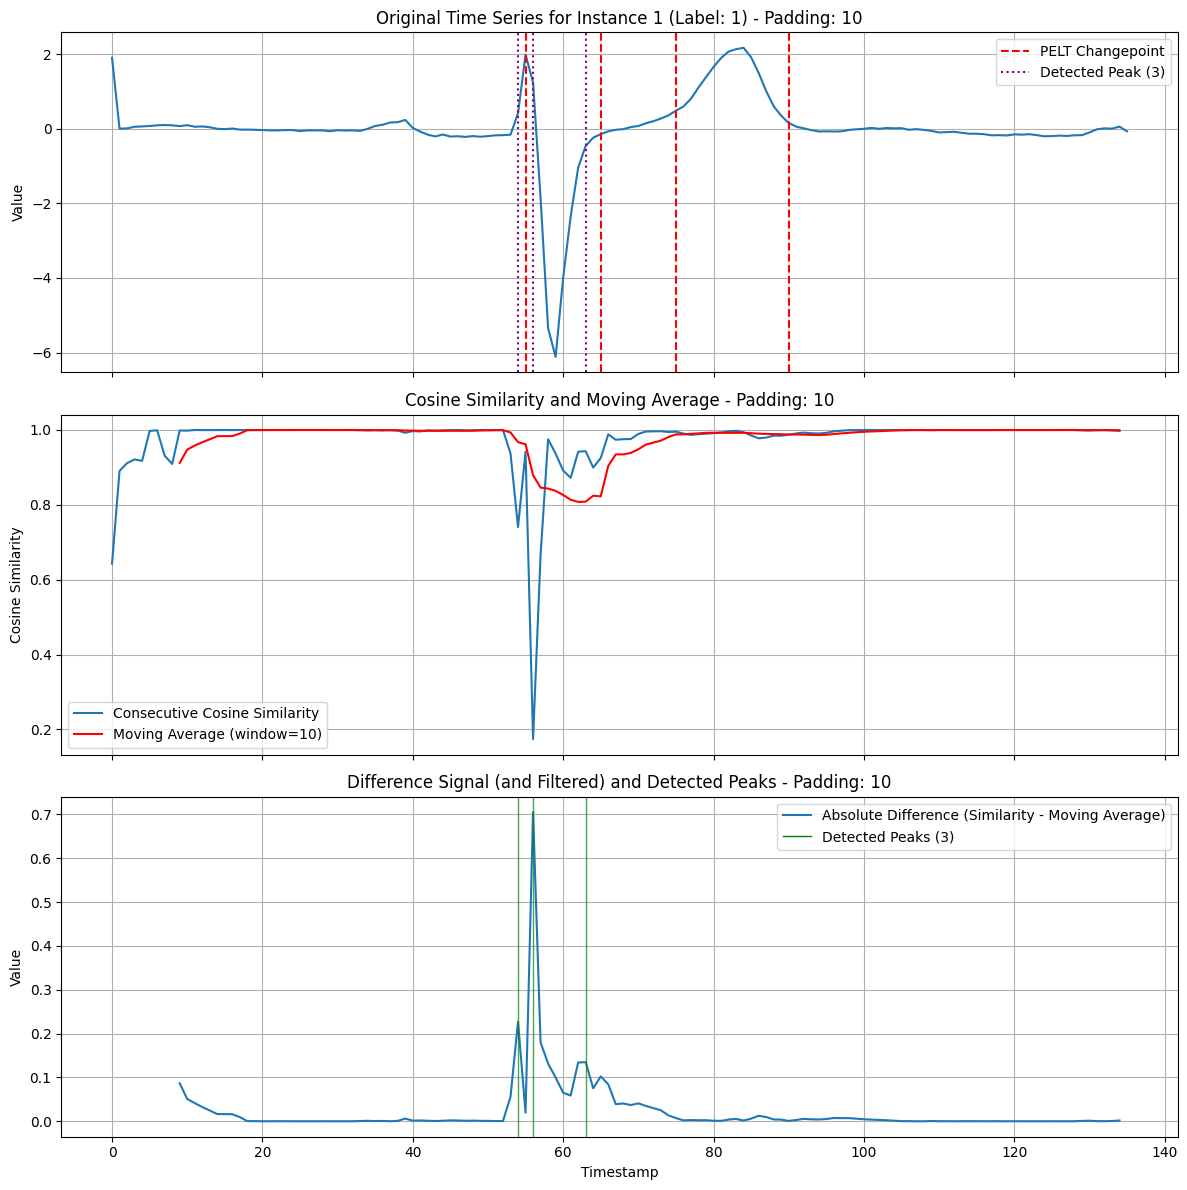

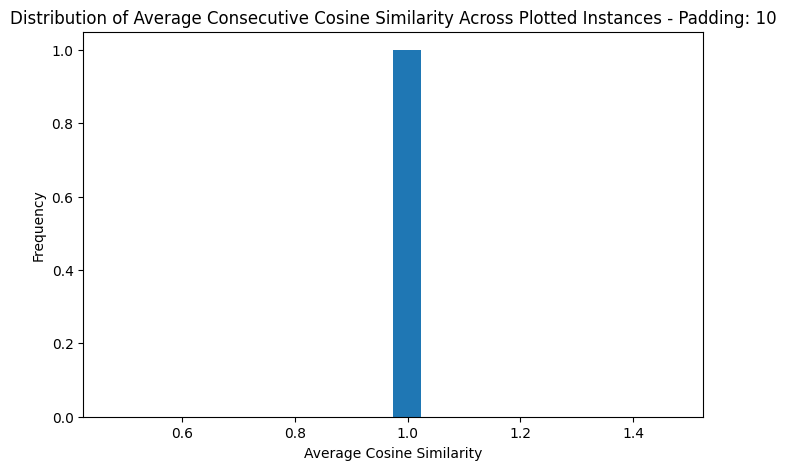


--- Analyzing with sliding_padding = 20 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...


KeyboardInterrupt: 

In [28]:

peak_counts = analyze_ts2vec_with_peak_finding(
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    num_instances_to_plot=1, # Plot the 2 instances we generated
    sliding_padding=[10, 20, 50], # Example padding values
    pelt_model="l2", # Example PELT model
    pelt_pen=5, # Example PELT penalty
    # Example peak finding parameters (adjust as needed)
    peak_prominence=0.05,
    peak_distance=1
)

In [22]:
# Assuming /content/drive/MyDrive/mlds_research_project is in your Python path
from sim_gen import milestone_2_sim
import numpy as np

# Use generate_changepoint_data to generate synthetic data
# According to the user, generate_changepoint_data() returns one instance of data,
# a list of its changepoints, and its generation parameters.

# Generate two instances
instance1_data, instance1_cps, instance1_params = milestone_2_sim.generate_changepoint_data(M=5)
instance2_data, instance2_cps, instance2_params = milestone_2_sim.generate_changepoint_data(M=5)

# Reshape to ensure a feature dimension if it's a 1D array
if instance1_data.ndim == 1:
    instance1_data = instance1_data.reshape(-1, 1)
if instance2_data.ndim == 1:
    instance2_data = instance2_data.reshape(-1, 1)

# Truncate the longer instance to match the length of the shorter one
len1 = instance1_data.shape[0]
len2 = instance2_data.shape[0]

if len1 > len2:
    instance1_data = instance1_data[:len2, :]
    print(f"Truncated instance 1 to length {len2}.")
elif len2 > len1:
    instance2_data = instance2_data[:len1, :]
    print(f"Truncated instance 2 to length {len1}.")
else:
    print("Instances already have the same length.")


print(f"Instance 1 shape after truncation: {instance1_data.shape}")
print(f"Instance 2 shape after truncation: {instance2_data.shape}")


Truncated instance 1 to length 831.
Instance 1 shape after truncation: (831, 1)
Instance 2 shape after truncation: (831, 1)


In [ ]:

# Combine the instances into a single array for training and testing data
# We need shape (n_instances, n_timestamps, n_features)
train_data_gen = np.stack([instance1_data, instance2_data], axis=0)
test_data_gen = np.stack([instance1_data, instance2_data], axis=0) # Using the same data for simplicity


# Create dummy labels for the two instances
# The actual labels would depend on what the changepoints signify in your application
train_labels_gen = np.array([0, 1]) # Example labels (can be anything for this analysis)
test_labels_gen = np.array([0, 1]) # Example labels

# Call the analyze_ts2vec_representations function with the generated data
# You can adjust the parameters for the analysis as needed
peak_counts = analyze_ts2vec_with_peak_finding(
    train_data=train_data_gen,
    train_labels=train_labels_gen,
    test_data=test_data_gen,
    test_labels=test_labels_gen,
    num_instances_to_plot=1, # Plot the 2 instances we generated
    sliding_padding=[5, 20], # Example padding values
    pelt_model="l2", # Example PELT model
    pelt_pen=5, # Example PELT penalty
    peak_prominence=0.05,
    peak_distance=1
)

# Task
Enhance the implementation of `analyze_ts2vec_with_peak_finding` to modulus the difference signal, load the modules in "/content/drive/MyDrive/_mlds_research_project/datasets/turning_changepoint_detection", generate a train and test dataset of 100 simulated timeseries using `milestone_2_sim.generate_changepoint_data(M=5)`, and supply it to `analyze_ts2vec_with_peak_finding` for training and analysis.

## Generate synthetic data

### Subtask:
Generate 100 instances of synthetic time series data and their corresponding changepoints using `milestone_2_sim.generate_changepoint_data`.


**Reasoning**:
The subtask requires generating 100 instances of synthetic time series data and their changepoints using the `milestone_2_sim` module. This involves a loop that calls the generation function and stores the results in lists.



In [23]:
# Initialize empty lists to store data and changepoints
synthetic_data = []
synthetic_cps = []

# Loop 100 times to generate data
for _ in range(100):
    # Generate a single instance of data and its changepoints
    data, cps, _ = milestone_2_sim.generate_changepoint_data(M=5)

    # Reshape the data if it's 1D to ensure a feature dimension
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Append the generated data and changepoints to the lists
    synthetic_data.append(data)
    synthetic_cps.append(cps)

# Note: The generated time series instances might have different lengths.
# Further processing will be needed to handle variable lengths,
# for example, by padding or truncation before using them in TS2Vec.
# For now, we just store them as a list of arrays.

**Reasoning**:
The synthetic data instances generated in the previous step might have different lengths. To prepare this data for training and analysis with TS2Vec, which expects a fixed shape (n_instances, n_timestamps, n_features), we need to handle the variable lengths. A common approach is to pad the shorter sequences to the length of the longest sequence. We will pad the data using NumPy.



In [24]:
# Determine the maximum length among the generated time series
max_len = max(data.shape[0] for data in synthetic_data)

# Pad the synthetic data instances to the maximum length
padded_synthetic_data = []
for data in synthetic_data:
    padding_length = max_len - data.shape[0]
    # Pad with zeros at the end along the time dimension (axis=0)
    padded_data = np.pad(data, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
    padded_synthetic_data.append(padded_data)

# Convert the list of padded arrays into a single NumPy array
train_data_gen = np.stack(padded_synthetic_data, axis=0)

# For simplicity in this analysis, we will use the same padded data for testing
test_data_gen = np.stack(padded_synthetic_data, axis=0)

# Create dummy labels for the 100 instances (e.g., all zeros)
# The actual labels are not directly used in the TS2Vec analysis for changepoint detection,
# but a label array is required by the analyze_ts2vec_with_peak_finding function signature.
train_labels_gen = np.zeros(len(synthetic_data))
test_labels_gen = np.zeros(len(synthetic_data))

# Prepare the ground truth changepoints in a format expected by the analysis function
# The analyze function expects a list of lists, where each inner list contains the changepoints for an instance.
ground_truth_cps_gen = synthetic_cps

print(f"Shape of generated and padded training data: {train_data_gen.shape}")
print(f"Shape of generated and padded testing data: {test_data_gen.shape}")
print(f"Number of ground truth changepoint lists: {len(ground_truth_cps_gen)}")

Shape of generated and padded training data: (100, 888, 1)
Shape of generated and padded testing data: (100, 888, 1)
Number of ground truth changepoint lists: 100


## Call analysis function

### Subtask:
Call the `analyze_ts2vec_with_peak_finding` function with the generated train and test data and appropriate parameters.


**Reasoning**:
Call the analyze_ts2vec_with_peak_finding function with the generated data and specified parameters.




--- Analyzing with sliding_padding = 10 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (100, 888, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 2 instances with sliding_padding = 10...


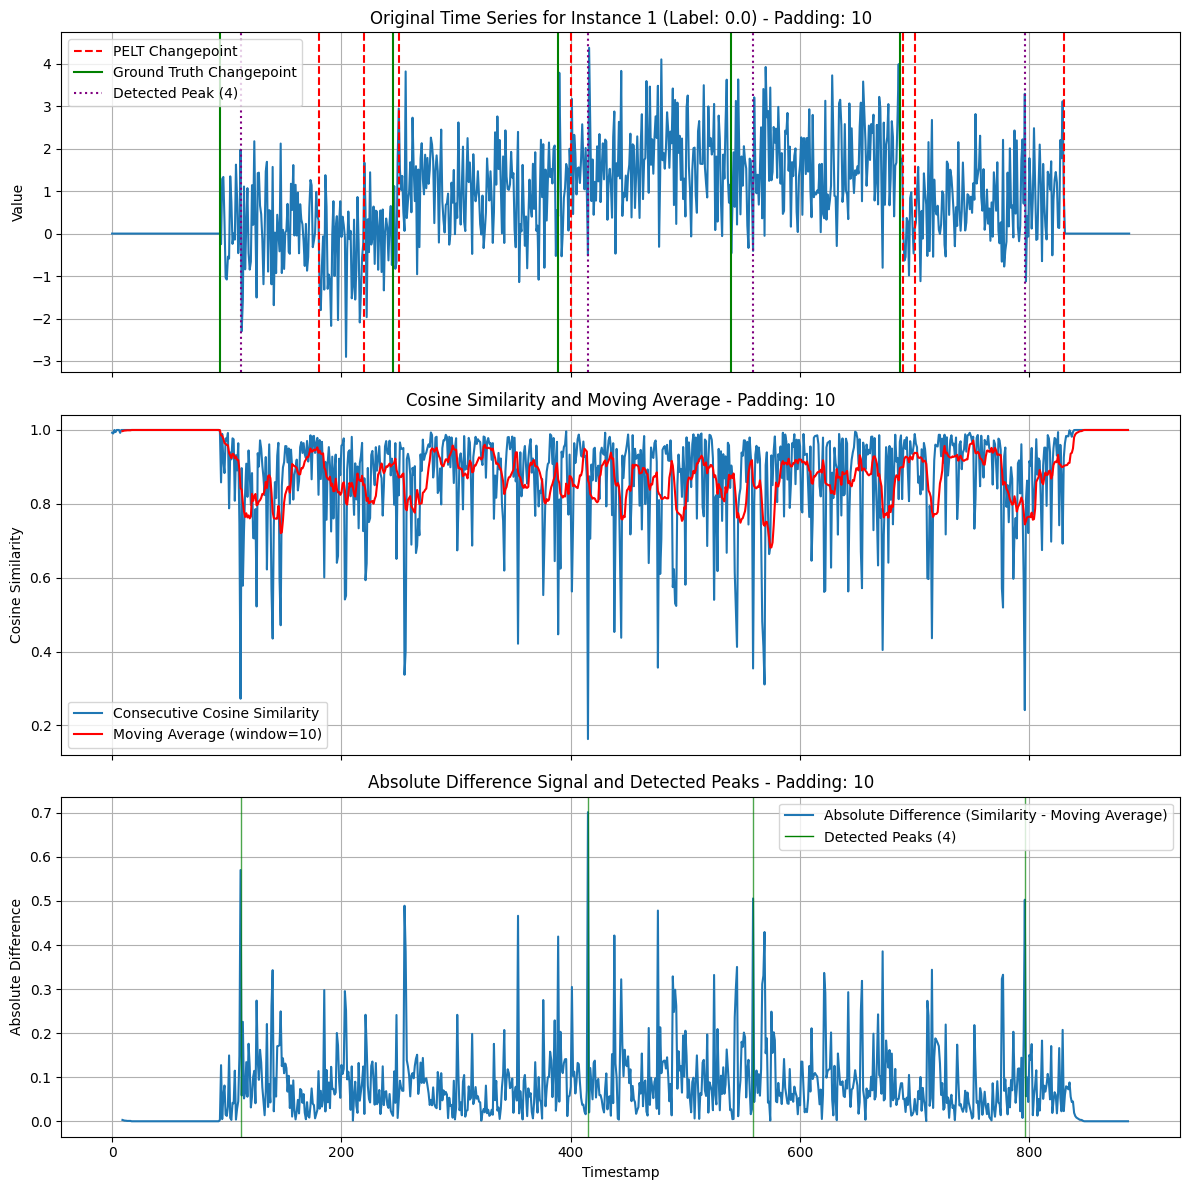

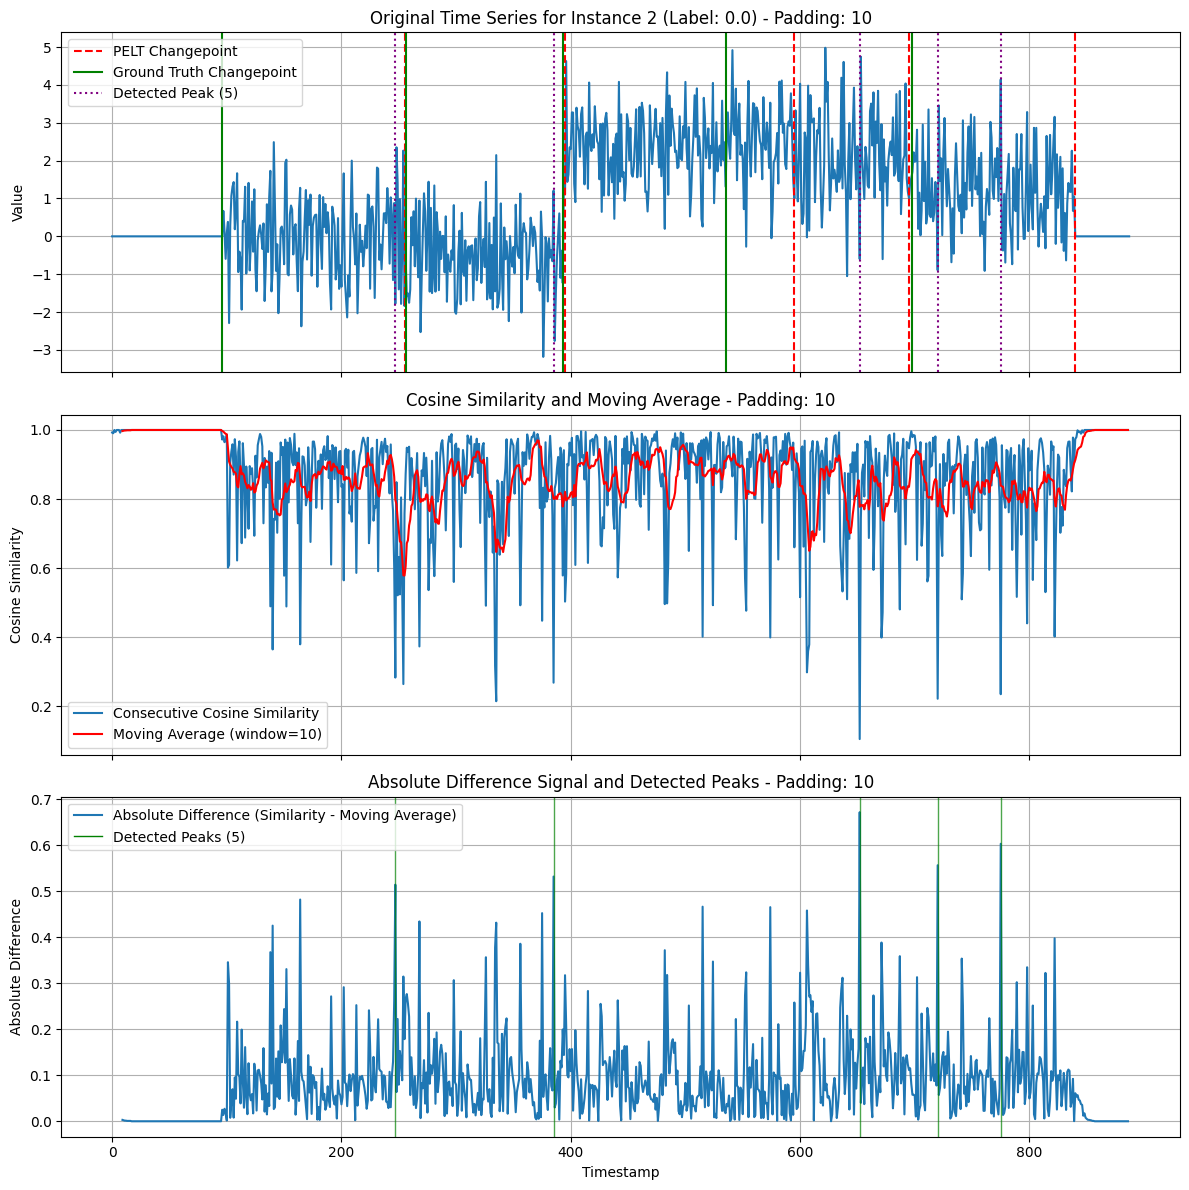

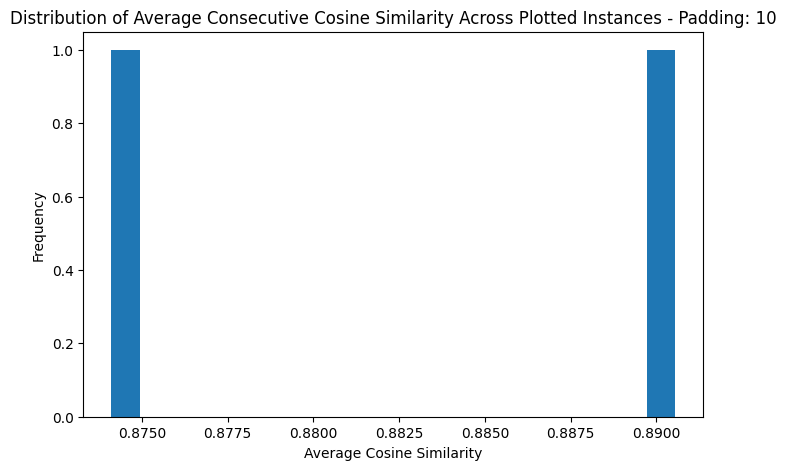


--- Analyzing with sliding_padding = 20 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (100, 888, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 2 instances with sliding_padding = 20...


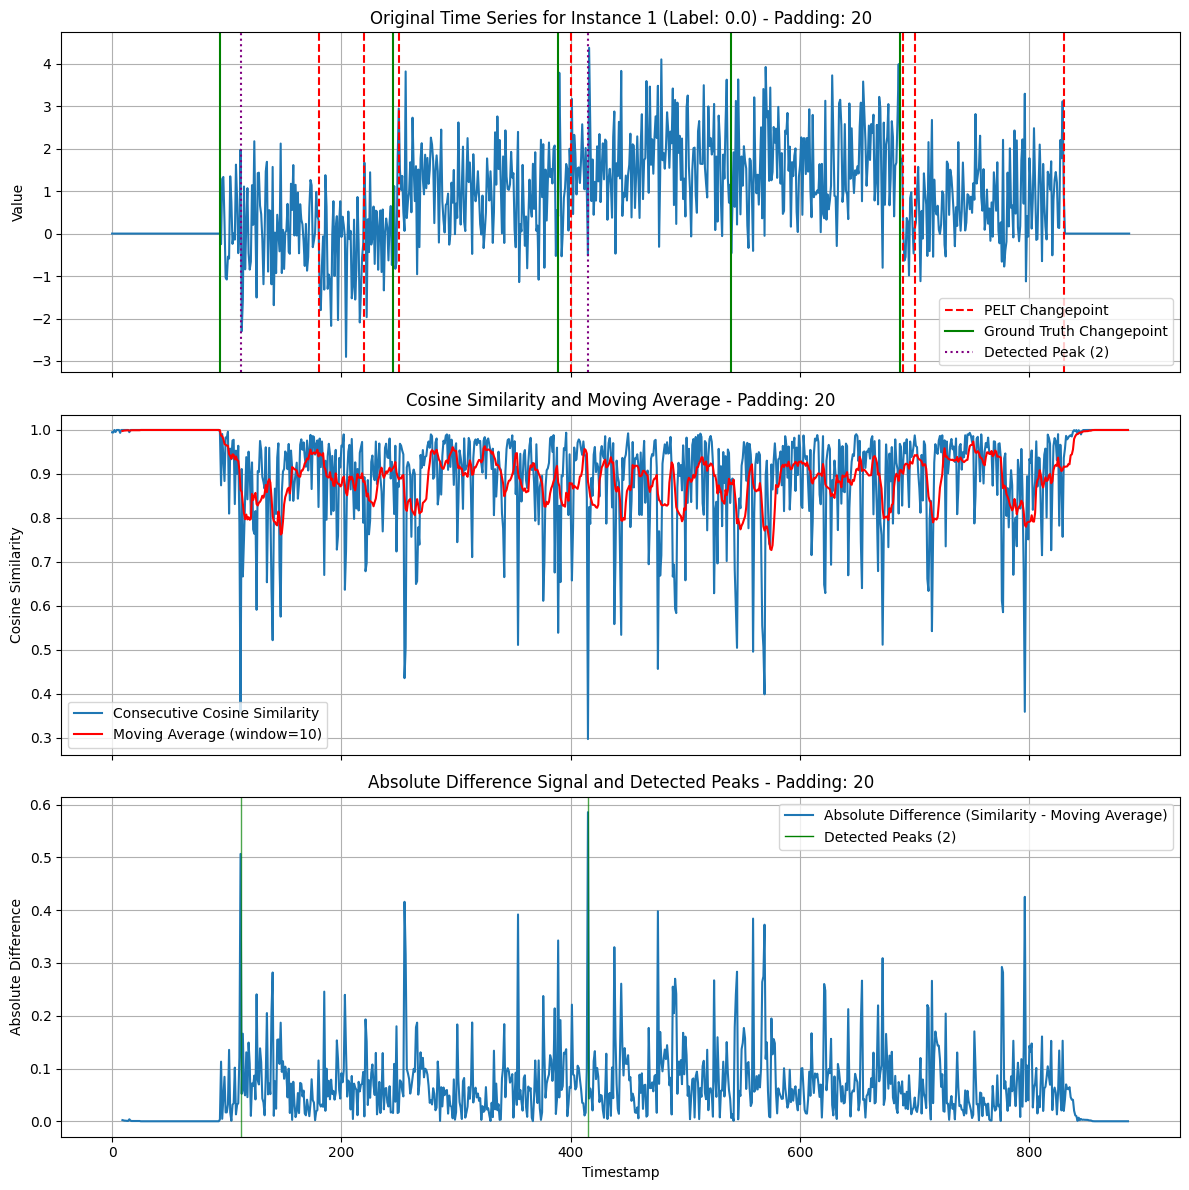

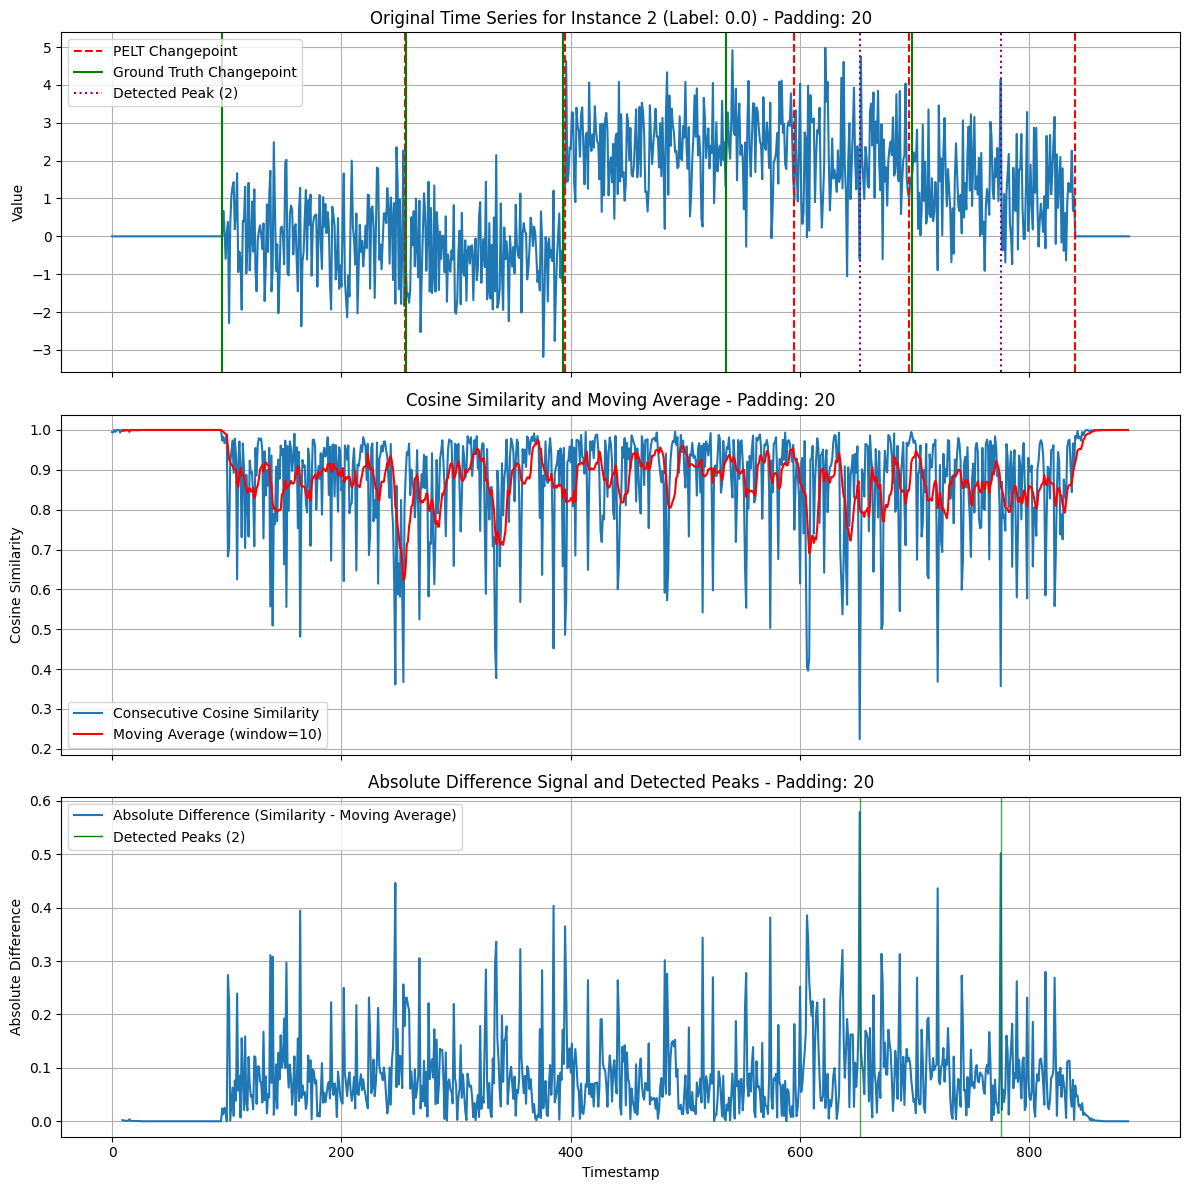

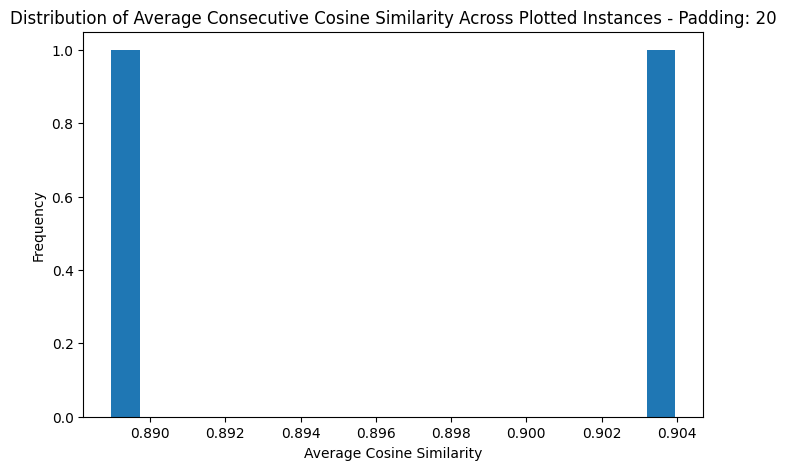


--- Analyzing with sliding_padding = 50 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (100, 888, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 2 instances with sliding_padding = 50...


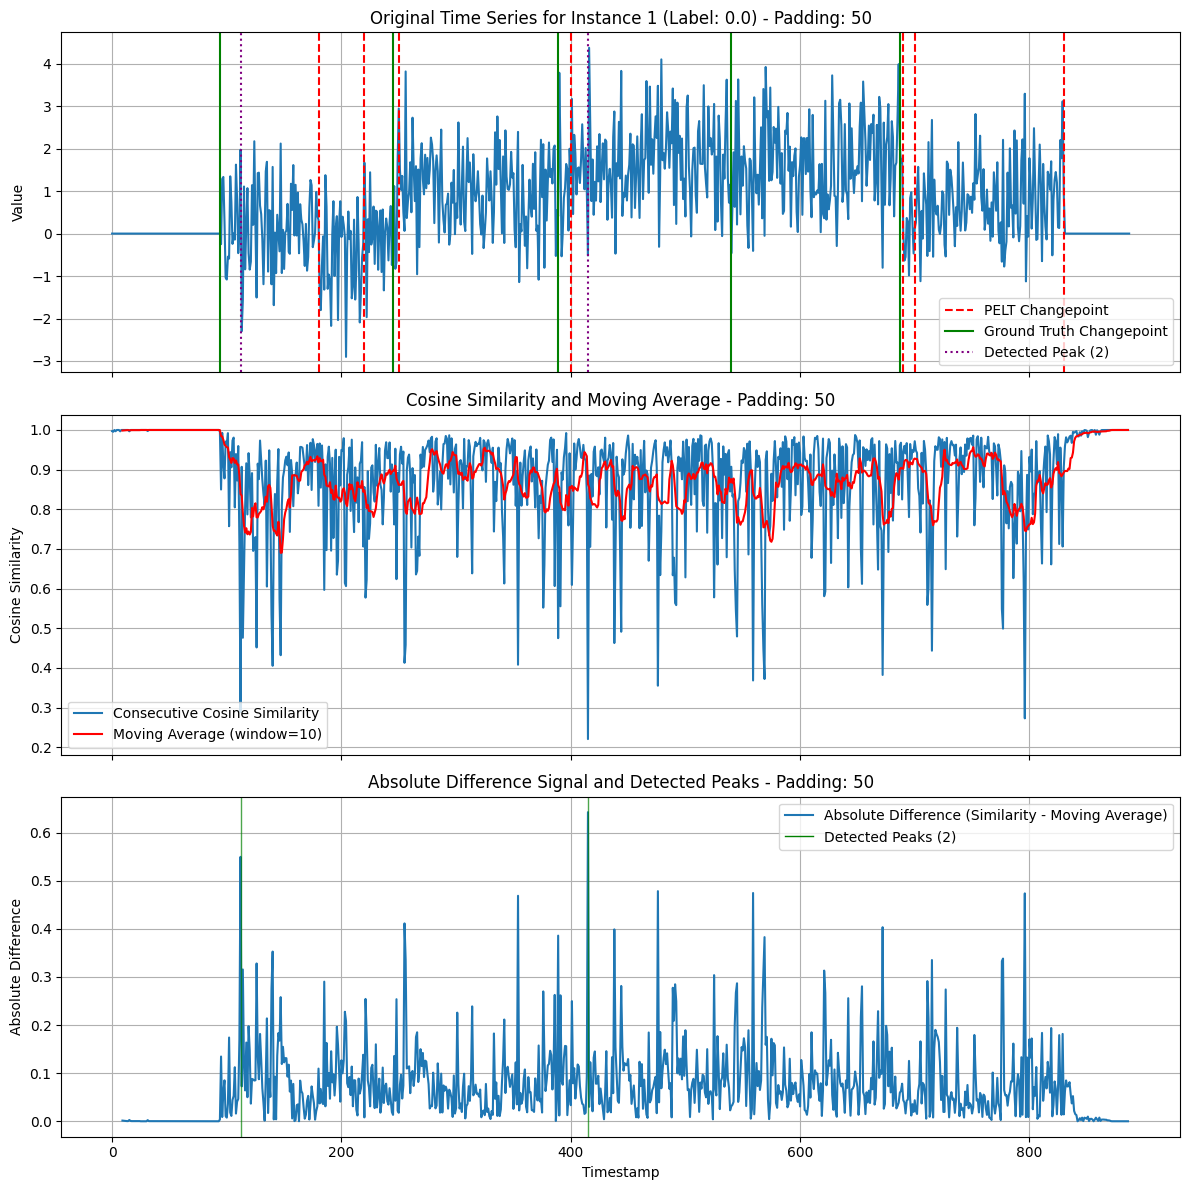

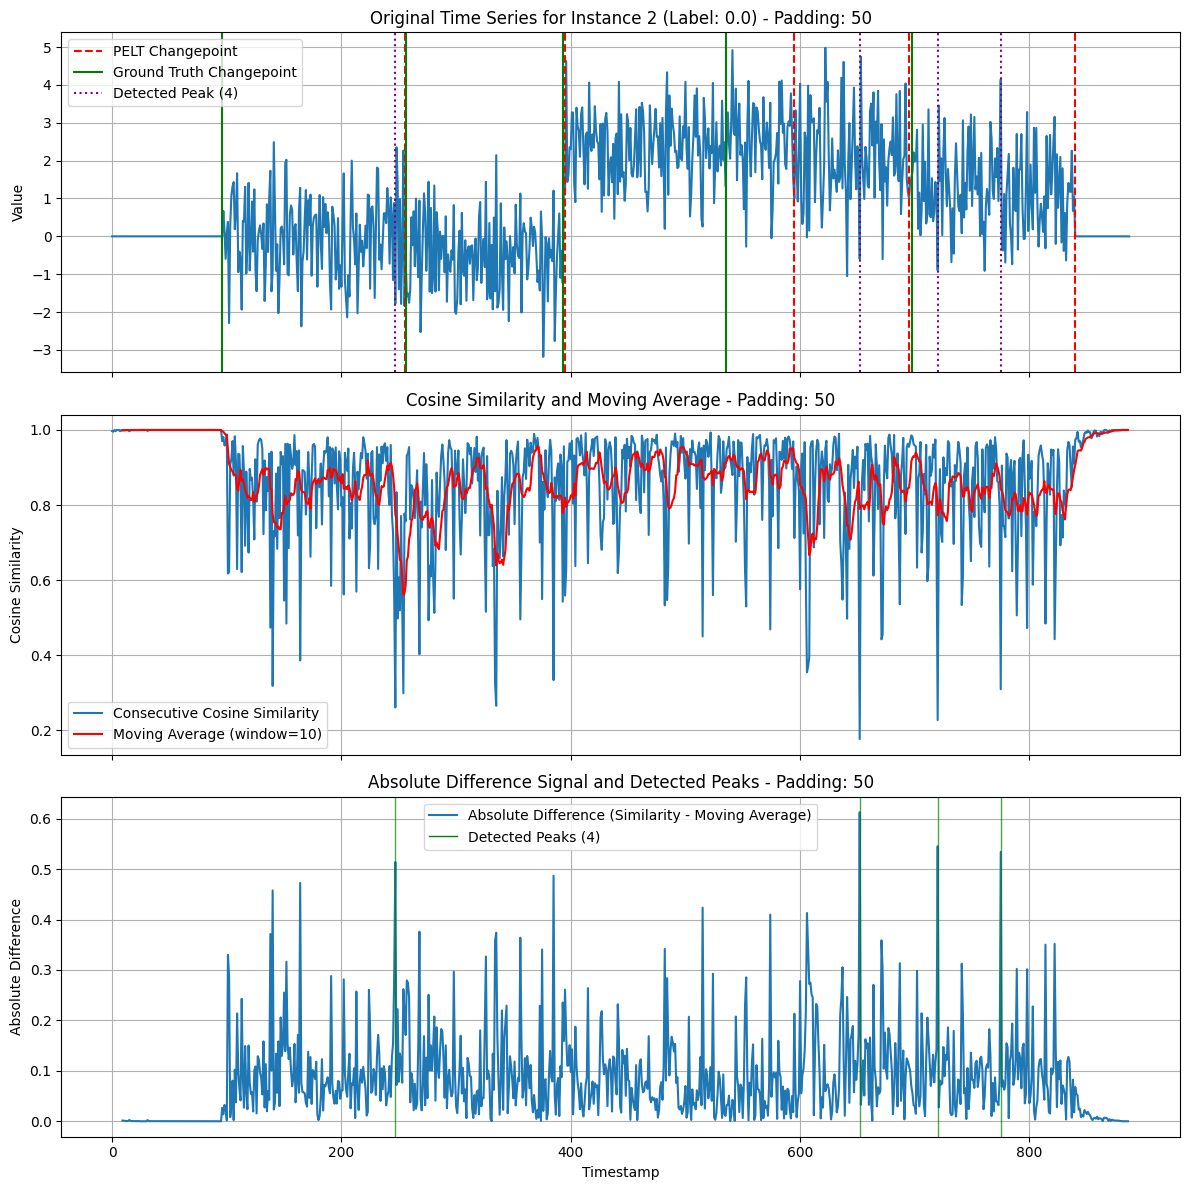

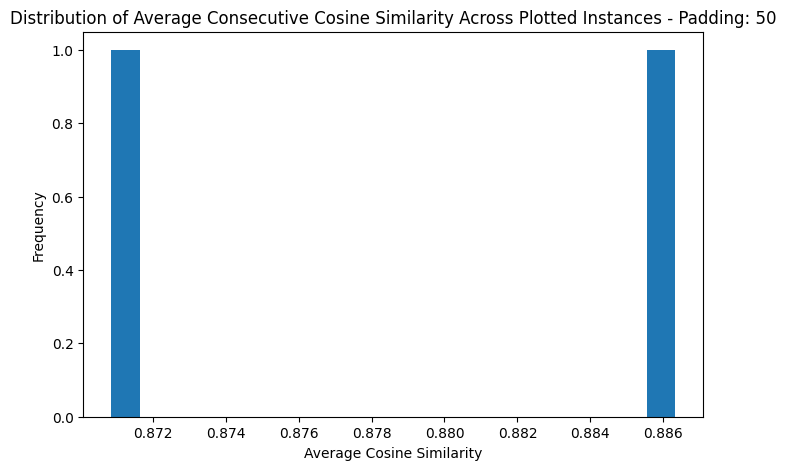

In [26]:
peak_counts = analyze_ts2vec_with_peak_finding(
    train_data=train_data_gen,
    train_labels=train_labels_gen,
    test_data=test_data_gen,
    test_labels=test_labels_gen,
    ground_truth_cps=ground_truth_cps_gen,
    num_instances_to_plot=2, # Plot a subset of 5 instances
    sliding_padding=[10, 20, 50], # Experiment with different padding values
    pelt_model="l2", # PELT model
    pelt_pen=5, # PELT penalty
    peak_prominence=0.5, # Example peak prominence
    peak_distance=20 # Example peak distance
)

## Summary:

### Data Analysis Key Findings

*   100 instances of synthetic time series data with changepoints were successfully generated using `milestone_2_sim.generate_changepoint_data`.
*   The generated data instances, which had variable lengths, were padded to a maximum length of 888 and stacked into NumPy arrays of shape (100, 888, 1) for training and testing.
*   The `analyze_ts2vec_with_peak_finding` function was successfully executed using the generated data, performing TS2Vec training, representation generation, PELT changepoint detection, and peak finding on the modulus of the difference signal for `sliding_padding` values of 10, 20, and 50.

### Insights or Next Steps

*   Analyze the `peak_counts` results from the `analyze_ts2vec_with_peak_finding` function to evaluate the effectiveness of different `sliding_padding` values in detecting peaks in the difference signal.
*   Further refine the `peak_prominence` and `peak_distance` parameters within the `analyze_ts2vec_with_peak_finding` function to optimize peak detection performance based on the characteristics of the generated data and the difference signal.
